In [70]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_dataset ,load_file
from utils.plot_utils import plot_targets
from utils.preprocessing import create_batch_sequences, create_sequences
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

In [2]:
root_dir = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"
sub_ids = [sub_id for sub_id in os.listdir(root_dir) if sub_id.startswith("sub-pp")]

In [4]:
ix_random_sub = np.random.choice(len(sub_ids), 1, replace=False)[0]
print(f"{ix_random_sub:d}: {sub_ids[ix_random_sub]:s}")
filenames = [fname for fname in os.listdir(os.path.join(root_dir, sub_ids[ix_random_sub], "motion")) if (fname.endswith("_events.tsv")) and ("_task-walk" in fname)]
ix_random_fname = np.random.choice(len(filenames), 1, replace=False)[0]
print(f"{ix_random_fname:d}: {filenames[ix_random_fname]:s}")

16: sub-pp017
2: sub-pp017_task-walkSlow_events.tsv


In [6]:
data, targets = load_file(os.path.join(root_dir, sub_ids[ix_random_sub], "motion", filenames[ix_random_fname]), tracked_points=["left_ankle"], normalize=False)

In [8]:
df_omc = pd.read_csv(os.path.join(root_dir, sub_ids[ix_random_sub], "motion", filenames[ix_random_fname].replace("_events.tsv", "_tracksys-omc_motion.tsv")), sep="\t", header=0)
df_omc.head()

,l_toe_POS_x,l_toe_POS_y,l_toe_POS_z,l_toe_POS_err,l_heel_POS_x,l_heel_POS_y,l_heel_POS_z,l_heel_POS_err,l_ank_POS_x,l_ank_POS_y,...,start_2_POS_z,start_2_POS_err,end_1_POS_x,end_1_POS_y,end_1_POS_z,end_1_POS_err,end_2_POS_x,end_2_POS_y,end_2_POS_z,end_2_POS_err
0,197.638915,580.497006,48.664061,1.747051,NaN,NaN,NaN,NaN,20.542365,544.654970,...,72.705331,1.590126,5684.300551,1856.327115,44.024638,2.097159,5834.573019,902.022794,37.370576,1.847314
1,197.641166,580.433928,48.615514,1.720833,NaN,NaN,NaN,NaN,20.444228,544.633305,...,72.725430,1.599987,5684.300036,1856.340027,44.030843,2.089495,5834.549695,901.907548,37.407660,1.681217
2,197.647366,580.410877,48.573468,1.858099,NaN,NaN,NaN,NaN,19.262032,545.459620,...,72.715407,1.578759,5684.294563,1856.348906,44.041100,2.105121,5834.552183,902.044046,37.413774,1.855823
3,197.620401,580.415900,48.576943,1.864426,NaN,NaN,NaN,NaN,20.468381,544.639768,...,72.701629,1.566124,5684.331469,1856.366051,44.034741,2.115349,5834.533775,901.901645,37.408637,1.648107
4,197.109740,579.710701,48.592797,1.630494,NaN,NaN,NaN,NaN,20.710606,543.461657,...,72.870983,1.612731,5684.587771,1856.249460,43.990343,2.126827,5835.325632,901.702937,36.877094,1.957055


In [25]:
df_events = pd.read_csv(os.path.join(root_dir, sub_ids[ix_random_sub], "motion", filenames[ix_random_fname]), sep="\t", header=0)
df_events.head()

,onset,duration,event_type
0,299,0,final_contact_left
1,382,0,initial_contact_left
2,453,0,final_contact_right
3,510,0,start
4,531,0,initial_contact_right


In [26]:
ix_start = df_events[df_events["event_type"]=="start"]["onset"].values[0]
ix_end   = df_events[df_events["event_type"]=="stop"]["onset"].values[0]

In [27]:
df_omc[["l_heel_POS_z","l_toe_POS_z"]].max().max()

237.602964158779

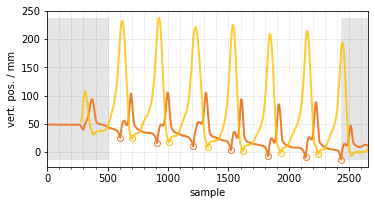

In [38]:
cm = 1/2.54
fig, axs = plt.subplots(1, 1, figsize=(13.5*cm, 7.5*cm))
axs.fill_between(np.arange(0, ix_start), np.ones((len(np.arange(0, ix_start)),))*df_omc[["l_heel_POS_z","l_toe_POS_z"]].max().max(), color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(0, ix_start), np.ones((len(np.arange(0, ix_start)),))*df_omc[["l_heel_POS_z","l_toe_POS_z"]].min().min(), color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(ix_end, len(df_omc)), np.ones((len(np.arange(ix_end, len(df_omc))),))*df_omc[["l_heel_POS_z","l_toe_POS_z"]].max().max(), color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(ix_end, len(df_omc)), np.ones((len(np.arange(ix_end, len(df_omc))),))*df_omc[["l_heel_POS_z","l_toe_POS_z"]].min().min(), color=(0, 0, 0), alpha=0.1, ec="none")
axs.plot(np.arange(len(df_omc)), df_omc["l_toe_POS_z"].iloc[:], '-', c=(0.929, 0.490, 0.192), lw=2)
axs.plot(np.arange(len(df_omc)), df_omc["l_heel_POS_z"].iloc[:], '-', c=(1.0, 0.752, 0), alpha=0.8, lw=2)
axs.plot(np.argwhere(targets["final_contact_left"]==1)[:,0]+ix_start, df_omc["l_toe_POS_z"].iloc[np.argwhere(targets["final_contact_left"]==1)[:,0]+ix_start], ls="none", marker="o", mfc="none", mec=(0.929, 0.490, 0.192))
axs.plot(np.argwhere(targets["initial_contact_left"]==1)[:,0]+ix_start, df_omc["l_heel_POS_z"].iloc[np.argwhere(targets["initial_contact_left"]==1)[:,0]+ix_start], ls="none", marker="o", mfc="none", mec=(1.0, 0.752, 0))
axs.set_xlim([0, len(df_omc)])
axs.xaxis.set_minor_locator(plt.MultipleLocator(100))
axs.grid(which="both", c=(0, 0, 0), alpha=0.2, ls=":")
axs.set_xlabel("sample")
axs.set_ylabel("vert. pos. / mm")
plt.tight_layout()
plt.savefig("D:\\Desktop\\fig_ppt_004.png", dpi=300)

In [82]:
# Get position data
pos = df_omc[["l_heel_POS_x", "l_heel_POS_y", "l_heel_POS_z", "l_toe_POS_x", "l_toe_POS_y", "l_toe_POS_z"]].iloc[ix_start:ix_end].to_numpy()
b, a = butter(N=6, Wn=20./(200/2), btype="low")
pos_filt = filtfilt(b, a, pos, axis=0, padtype = 'odd', padlen=3*(max(len(b),len(a))-1))

# Differentiate to get velocity
vel = np.diff(pos_filt, axis=0)/(1/200)
vel.shape

(1921, 6)

In [83]:
pks, pkprops = find_peaks(vel[:,0], distance=50)
print(pks)

[  21   92  161  223  278  397  460  515  595  695  778  829  902 1009
 1073 1140 1217 1317 1377 1429 1504 1625 1684 1734 1796 1856 1916]


In [76]:
np.max(vel)

2387.389591938154

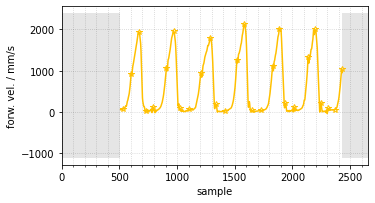

In [85]:
cm = 1/2.54
fig, axs = plt.subplots(1, 1, figsize=(13.5*cm, 7.5*cm))

axs.fill_between(np.arange(0, ix_start), np.ones((len(np.arange(0, ix_start)),))*np.max(vel), color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(0, ix_start), np.ones((len(np.arange(0, ix_start)),))*np.min(vel), color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(ix_end, len(df_omc)), np.ones((len(np.arange(ix_end, len(df_omc))),))*np.max(vel), color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(ix_end, len(df_omc)), np.ones((len(np.arange(ix_end, len(df_omc))),))*np.min(vel), color=(0, 0, 0), alpha=0.1, ec="none")
axs.plot(np.arange(ix_start+1, ix_end), vel[:,0], ls="-", c=(1.0, 0.752, 0))
axs.plot(pks+ix_start, vel[pks,0], ls="none", marker="*", mec=(1.0, 0.752, 0), mfc="none")
axs.set_xlim([0, len(df_omc)])
axs.xaxis.set_minor_locator(plt.MultipleLocator(100))
axs.grid(which="both", c=(0, 0, 0), alpha=0.2, ls=":")
axs.set_xlabel("sample")
axs.set_ylabel("forw. vel. / mm/s")
plt.tight_layout()
plt.savefig("D:\\Desktop\\fig_ppt_007.png", dpi=300)

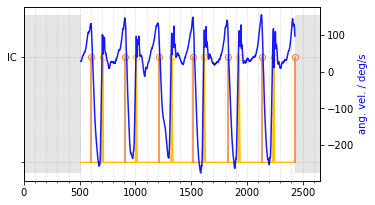

In [63]:
cm = 1/2.54
fig, axs = plt.subplots(1, 1, figsize=(13.5*cm, 7.5*cm))

axs.fill_between(np.arange(0, ix_start), np.ones((len(np.arange(0, ix_start)),))*1.4, color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(0, ix_start), np.ones((len(np.arange(0, ix_start)),))*-0.1, color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(ix_end, len(df_omc)), np.ones((len(np.arange(ix_end, len(df_omc))),))*1.4, color=(0, 0, 0), alpha=0.1, ec="none")
axs.fill_between(np.arange(ix_end, len(df_omc)), np.ones((len(np.arange(ix_end, len(df_omc))),))*-0.1, color=(0, 0, 0), alpha=0.1, ec="none")
axs.plot(np.arange(ix_start, ix_end), targets["initial_contact_left"], ls="-", c=(1.0, 0.752, 0))
for ix in np.argwhere(targets["initial_contact_left"]==1)[:,0]:
    axs.plot([ix+ix_start, ix+ix_start], [0.0, 1.0], ls="-", c=(1.0, 0.752, 0))
    axs.plot([ix+ix_start,], [1.0,], ls="none", marker="o", mfc="none", mec=(1.0, 0.752, 0))
for ix in np.argwhere(targets["final_contact_left"]==1)[:,0]:
    axs.plot([ix+ix_start, ix+ix_start], [0.0, 1.0], ls="-", c=(0.929, 0.490, 0.192))
    axs.plot([ix+ix_start,], [1.0,], ls="none", marker="o", mfc="none", mec=(0.929, 0.490, 0.192))
axs.set_xlim([0, len(df_omc)])
axs.xaxis.set_minor_locator(plt.MultipleLocator(100))
axs.grid(which="both", c=(0, 0, 0), alpha=0.2, ls=":")
axs.set_ylabel("")
axs.set_yticks((0, 1))
axs.set_yticklabels(("", "IC"))
axs_ = axs.twinx()
axs_.plot(np.arange(ix_start, ix_end), data[:,5], ls="-", c=(0, 0, 1), alpha=0.9)
axs_.set_ylabel("ang. vel. / deg/s", color=(0, 0, 1))
plt.tight_layout()
plt.savefig("D:\\Desktop\\fig_ppt_006.png", dpi=300)

In [24]:
print(len(df_omc))
print(targets["initial_contact_left"].shape)

2657
(1922, 1)


In [3]:
ds = load_dataset(root_dir, sub_ids=sub_ids, tracked_points=["left_ankle", "right_ankle"], normalize=True)

Z:\Keep Control\Data\lab dataset\rawdata\sub-pp162\motion\sub-pp162_task-walkFast_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp162\motion\sub-pp162_task-walkPreferred_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp162\motion\sub-pp162_task-walkSlow_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp163\motion\sub-pp163_task-walkFast_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp163\motion\sub-pp163_task-walkPreferred_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp163\motion\sub-pp163_task-walkSlow_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\raw

In [4]:
WIN_LEN = 400
STEP_LEN = 200
data, targets, list_filenames, list_filenames_examples = create_batch_sequences(ds, win_len=WIN_LEN, step_len=STEP_LEN)

In [5]:
print(f"Shape of data: {data.shape}")
for k in targets.keys():
    print(f"Shape of {k}: {targets[k].shape}")
print(f"Number of filenames: {len(list_filenames)}")

Shape of data: (2186, 400, 18)
Shape of initial_contact_left: (2186, 400, 1)
Shape of final_contact_left: (2186, 400, 1)
Shape of initial_contact_right: (2186, 400, 1)
Shape of final_contact_right: (2186, 400, 1)
Number of filenames: 2186


98: sub-pp011_task-walkSlow


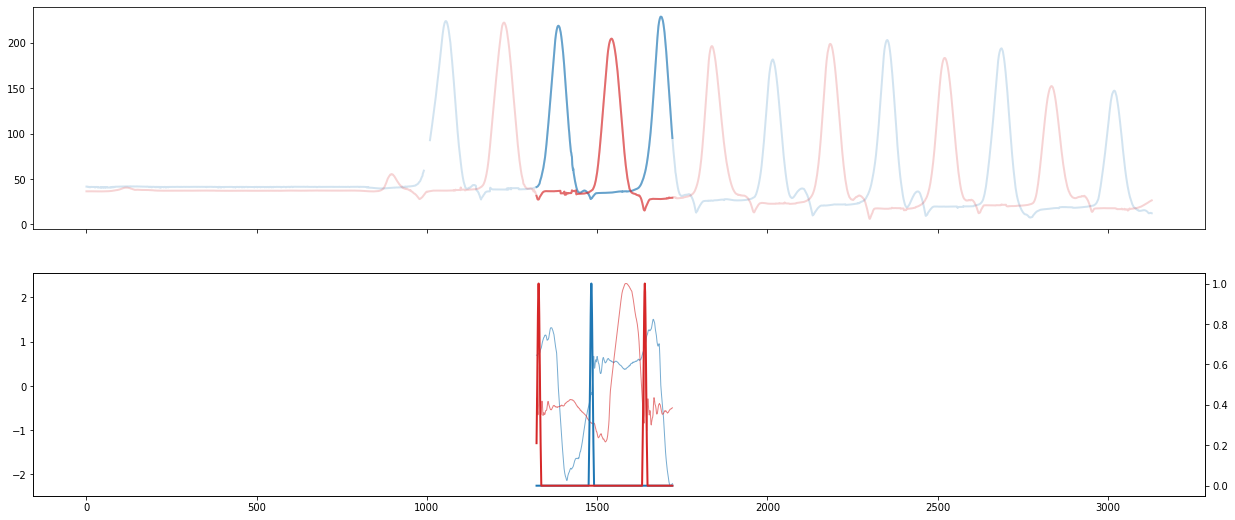

In [6]:
# Select a random example
ix_example = np.random.choice(data.shape[0], 1, replace=False)[0]
ix_window = ix_example - list_filenames.index(list_filenames[ix_example])

# Get filename prefix belonging to this example
filename_prefix = list_filenames[ix_example]
print(f"{ix_example:d}: {filename_prefix:s}")

# Read data
df_omc = pd.read_csv(os.path.join(root_dir, filename_prefix[:9], "motion", filename_prefix+"_tracksys-omc_motion.tsv"), sep="\t", header=0)
df_imu = pd.read_csv(os.path.join(root_dir, filename_prefix[:9], "motion", filename_prefix+"_tracksys-imu_motion.tsv"), sep="\t", header=0)
df_events = pd.read_csv(os.path.join(root_dir, filename_prefix[:9], "motion", filename_prefix+"_events.tsv"), sep="\t", header=0)
ix_start  = df_events[df_events["event_type"]=="start"]["onset"].values[0]
ix_end    = df_events[df_events["event_type"]=="stop"]["onset"].values[0]

# Plot figure
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(21, 9))
axs[0].plot(np.arange(len(df_omc)), df_omc["l_heel_POS_z"].iloc[:], c="tab:blue", alpha=0.2, lw=2)
axs[0].plot(np.arange(len(df_omc)), df_omc["r_heel_POS_z"].iloc[:], c="tab:red", alpha=0.2, lw=2)
axs[0].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), df_omc["l_heel_POS_z"].iloc[ix_start+ix_window*STEP_LEN:ix_start+ix_window*STEP_LEN+WIN_LEN], c="tab:blue", alpha=0.6, lw=2)
axs[0].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), df_omc["r_heel_POS_z"].iloc[ix_start+ix_window*STEP_LEN:ix_start+ix_window*STEP_LEN+WIN_LEN], c="tab:red", alpha=0.6, lw=2)

axs[1].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), data[ix_example][:,5], c="tab:blue", alpha=0.6, lw=1)
axs[1].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), data[ix_example][:,14], c="tab:red", alpha=0.6, lw=1)
axs_ = axs[1].twinx()
axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_left"][ix_example][:,0], c="tab:blue", lw=2)
# axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_left"][ix_example][:,0], c="tab:blue", lw=2)
axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_right"][ix_example][:,0], c="tab:red", lw=2)
# axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_left"][ix_example][:,0], c="tab:blue", lw=2)
plt.show()


In [7]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary

In [14]:
def build_model(input_dim, target_classes):
    # Define layers
    inputs = keras.layers.Input(shape=(None, input_dim), name="inputs")
    tcn = TCN(nb_filters=16, kernel_size=5, nb_stacks=1, dilations=[1, 2], padding="same", use_skip_connections=True, use_batch_norm=True, return_sequences=True, name="tcn")(inputs)
    outputs = []
    for i in range(len(target_classes)):
        outputs.append(keras.layers.Dense(units=1, activation="sigmoid", name=target_classes[i])(tcn))
    
    # Instantiate model
    model = keras.models.Model(inputs=inputs, outputs=outputs, name="tcn_model")

    # Compile
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

In [15]:
model = build_model(data.shape[-1], target_classes=list(targets.keys()))
model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 18)]   0           []                               
                                                                                                  
 tcn (TCN)                      (None, None, 16)     5904        ['inputs[0][0]']                 
                                                                                                  
 initial_contact_left (Dense)   (None, None, 1)      17          ['tcn[0][0]']                    
                                                                                                  
 final_contact_left (Dense)     (None, None, 1)      17          ['tcn[0][0]']                    
                                                                                          

In [16]:
history = model.fit(x=data, y=targets, batch_size=8, epochs=5, validation_split=0.1)

Epoch 1/5
246/246 [==============================] - 10s 29ms/step - loss: 0.3305 - initial_contact_left_loss: 0.0806 - final_contact_left_loss: 0.0502 - initial_contact_right_loss: 0.1395 - final_contact_right_loss: 0.0602 - val_loss: 0.0798 - val_initial_contact_left_loss: 0.0234 - val_final_contact_left_loss: 0.0230 - val_initial_contact_right_loss: 0.0199 - val_final_contact_right_loss: 0.0135
Epoch 2/5
246/246 [==============================] - 6s 25ms/step - loss: 0.0508 - initial_contact_left_loss: 0.0133 - final_contact_left_loss: 0.0128 - initial_contact_right_loss: 0.0144 - final_contact_right_loss: 0.0103 - val_loss: 0.0374 - val_initial_contact_left_loss: 0.0111 - val_final_contact_left_loss: 0.0088 - val_initial_contact_right_loss: 0.0107 - val_final_contact_right_loss: 0.0068
Epoch 3/5
246/246 [==============================] - 7s 29ms/step - loss: 0.0379 - initial_contact_left_loss: 0.0100 - final_contact_left_loss: 0.0093 - initial_contact_right_loss: 0.0099 - final_con

In [17]:
predictions = model.predict(data, batch_size=16)

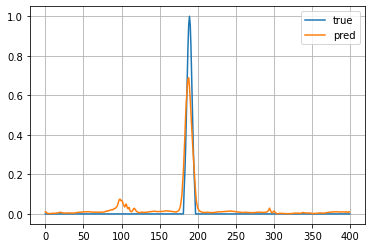

In [48]:
indx_example = np.random.choice(data.shape[0], 1, replace=False)[0]

plt.plot(targets["final_contact_right"][indx_example][:,0], label='true')
plt.plot(predictions[3][indx_example][:,0], label='pred')

plt.grid()
plt.legend()
plt.show()